In [1]:
from PIL import Image
import numpy as np
import os
from pylab import *

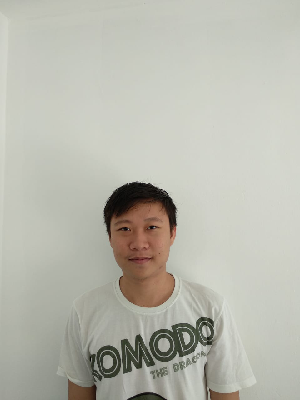

In [2]:
image = array(Image.open('agus2.jpeg').resize((300, 400)))
Image.fromarray(image)

In [3]:
image_new = image.copy()
for idx_row, row in enumerate(image):
    for idx_col, column in enumerate(row):
        image_new[idx_row][idx_col][0] = 0.299 * image[idx_row][idx_col][0] + 0.587 * image[idx_row][idx_col][1] + 0.114 * image[idx_row][idx_col][2]
        image_new[idx_row][idx_col][1] = 128 - 0.169 * image[idx_row][idx_col][0] - 0.331 * image[idx_row][idx_col][1] + 0.5 * image[idx_row][idx_col][2]
        image_new[idx_row][idx_col][2] = 128 + 0.5 * image[idx_row][idx_col][0] - 0.419 * image[idx_row][idx_col][1] - 0.081 * image[idx_row][idx_col][2]

In [4]:
# ( Y > 50)and (Y < 175) and
#  ( Cb > 90)and (Cb < 120) and ……….. (4)
#  ( Cr > 140)and (Cr < 165) and
#  ( Cr > 𝐶b)and (Cr − Cb > 15)
def isSkinColor(pixel):
    return pixel[0] > 80 and pixel[1] > 85 and pixel[1] < 135 and pixel[2] > 135 and pixel[2] < 180
#     return pixel[0] > 50 and pixel[0] < 175 and pixel[1] > 90 and pixel[1] < 120 and pixel[2] > 140 and pixel[2] < 165 and pixel[2] > pixel[1] and pixel[2] - pixel[1] > 15

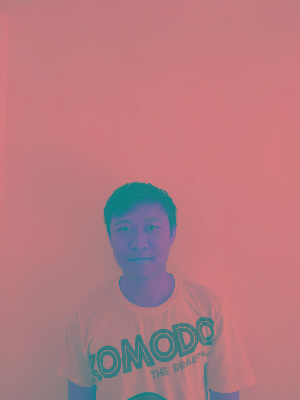

In [5]:
Image.fromarray(image_new)

In [6]:
image_face = image_new.copy()

In [7]:
for idx_row, row in enumerate(image_face):
    for idx_col, col in enumerate(row):
        if isSkinColor(col):
            image_face[idx_row][idx_col] = 255
        else:
            image_face[idx_row][idx_col] = 0

In [8]:
image = Image.fromarray(image_face).convert('L')

In [9]:
image_arr = array(image)

In [10]:
image_arr.shape

(400, 300)

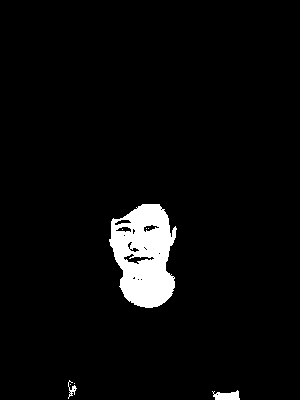

In [11]:
Image.fromarray(image_arr)

In [12]:
def flood_fill(image_arr, row_start, col_start):
    global min_x, min_y, max_x, max_y
    if (row_start < image_arr.shape[0] and col_start < image_arr.shape[1]):
        if (image_arr[row_start][col_start] == 255):
            if (row_start < min_y):
                min_y = row_start
            if (row_start > max_y):
                max_y = row_start
            if (col_start < min_x):
                min_x = col_start
            if (col_start > max_x):
                max_x = col_start
                
            image_arr[row_start][col_start] = 0
            flood_fill(image_arr, row_start + 1, col_start) # bottom
            flood_fill(image_arr, row_start - 1, col_start) # top
            flood_fill(image_arr, row_start, col_start + 1) # right
            flood_fill(image_arr, row_start, col_start - 1) # left
            flood_fill(image_arr, row_start - 1, col_start - 1) # upper left
            flood_fill(image_arr, row_start - 1, col_start + 1) # upper right
            flood_fill(image_arr, row_start + 1, col_start - 1) # bottom left
            flood_fill(image_arr, row_start + 1, col_start + 1) # bottom right

In [13]:
candidate_face = []
for idx_row, row in enumerate(image_arr):
    for idx_col, col in enumerate(row):
        if col == 255:
            max_x = -9999
            max_y = -9999
            min_x = 9999
            min_y = 9999
            flood_fill(image_arr, idx_row, idx_col)
            candidate_face.append((min_x, max_x, min_y, max_y))

/home/agus/anaconda3/envs/basic/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


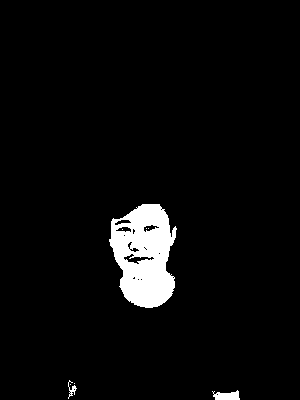

In [14]:
Image.fromarray(image_face)

In [15]:
def filter_with_ratio(candidate_face):
    result = []
    for min_col, max_col, min_row, max_row in candidate_face:
        width = max_col - min_col
        height = max_row - min_row
        if width != 0:
            ratio = height / width
            if (ratio >= 1.5 and ratio <= 2.8):
                result.append((min_col, max_col, min_row, max_row))
                
    return result

In [16]:
ratio_filter_result = filter_with_ratio(candidate_face)

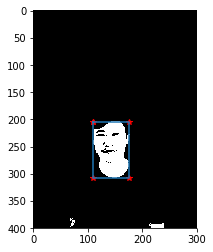

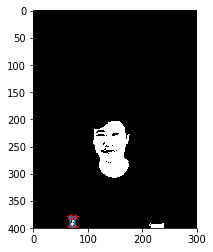

In [17]:
for min_col, max_col, min_row, max_row in ratio_filter_result:
    x = [min_col, max_col, max_col, min_col, min_col]
    y = [min_row, min_row, max_row, max_row, min_row]
    imshow(image_face)
    plot(x, y, 'r*')
    plot(x, y)
    show()

In [18]:
def sum_region(left_top_corner, right_bottom_corner, image_arr):
    sum_result = 0
    left = left_top_corner[0]
    top = left_top_corner[1]
    right = right_bottom_corner[0]
    bottom = right_bottom_corner[1]
    for idx_row in range(top, bottom):
        for idx_col in range(left, right):
                if image_arr[idx_row][idx_col] == 0:
                    sum_result += 1
        
    return sum_result

def find_mouth(image_face_arr):
    mouth_width = 30
    mouth_height = 12

    maks = 0
    found = False
    mouth_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(len(image_face_arr)):
        for idx_col in range(len(image_face_arr[0])):
            if idx_col + mouth_width >= image_face_arr.shape[1]: #OOB
                break

            white = sum_region((idx_col, idx_row), (idx_col + mouth_width, idx_row + mouth_height // 2), image_face_arr)
            black = sum_region((idx_col, idx_row + mouth_height // 2), (idx_col + mouth_width, idx_row + mouth_height), image_face_arr)
            if black - white >= maks and black - white >= 75:
                maks = black - white
                mouth_position[0][0] = idx_col
                mouth_position[0][1] = idx_row + mouth_height // 2
                mouth_position[1][0] = idx_col + mouth_width
                mouth_position[1][1] = idx_row + mouth_height
            
        if idx_row + mouth_height >= image_face_arr.shape[0]:
            break
    print(maks, mouth_position)
    
    mouth_position.append(maks)
    return mouth_position

def find_nose(image_face_arr, mouth_top_position, mouth_left_position, mouth_right_position):
    nose_width = 18
    nose_height = 20

    maks = 0
    found = False
    nose_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(mouth_top_position - 22, mouth_top_position - nose_height):
        for idx_col in range(mouth_left_position, mouth_right_position - nose_width):
            if idx_col + nose_width >= image_face_arr.shape[1]: #OOB
                break

            black1 = sum_region((idx_col, idx_row), (idx_col + (nose_width // 3), idx_row + nose_height), image_face_arr)
            white = sum_region((idx_col + (nose_width // 3), idx_row), (idx_col + ((nose_width * 2) // 3), idx_row + nose_height), image_face_arr)
            black2 = sum_region((idx_col + ((nose_width * 2) // 3), idx_row), (idx_col + nose_width, idx_row + nose_height), image_face_arr)
            if (black1 + black2) - white >= maks and (black1 + black2) - white >= 15:
                maks = black1 + black2 - white
                nose_position[0][0] = idx_col
                nose_position[0][1] = idx_row
                nose_position[1][0] = idx_col + nose_width
                nose_position[1][1] = idx_row + nose_height
        if idx_row + nose_height >= image_face_arr.shape[0]:
            break
    print(maks, nose_position)
    
    nose_position.append(maks)
    return nose_position

def find_left_eye(image_face_arr, nose_top_position, nose_left_position):
    left_eye_width = 20
    left_eye_height = 12
    print(nose_top_position, nose_left_position)
    maks = 0
    found = False
    left_eye_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(nose_top_position - 10, nose_top_position):
        for idx_col in range(nose_left_position + 5):
            if idx_col + left_eye_width >= image_face_arr.shape[1]: #OOB
                break

            black = sum_region((idx_col, idx_row), (idx_col + left_eye_width, idx_row + left_eye_height // 2), image_face_arr)
            white = sum_region((idx_col, idx_row + left_eye_height // 2), (idx_col + left_eye_width, idx_row + left_eye_height), image_face_arr)
            if black - white >= maks and black - white >= 35:
                maks = black - white
                left_eye_position[0][0] = idx_col
                left_eye_position[0][1] = idx_row
                left_eye_position[1][0] = idx_col + left_eye_width
                left_eye_position[1][1] = idx_row + left_eye_height // 2
        if idx_row + left_eye_height >= image_face_arr.shape[0]:
            break
    print(maks, left_eye_position)
    
    left_eye_position.append(maks)
    return left_eye_position

def find_right_eye(image_face_arr, left_eye_top, left_eye_bottom, left_eye_right):
    right_eye_width = 20
    right_eye_height = 12

    maks = 0
    found = False
    right_eye_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(left_eye_top, left_eye_bottom):
        for idx_col in range(left_eye_right, len(image_face_arr[0])):
            if idx_col + right_eye_width >= image_face_arr.shape[1]: #OOB
                break

            black = sum_region((idx_col, idx_row), (idx_col + right_eye_width, idx_row + right_eye_height // 2), image_face_arr)
            white = sum_region((idx_col, idx_row + right_eye_height // 2), (idx_col + right_eye_width, idx_row + right_eye_height), image_face_arr)
            if black - white >= maks and black - white >= 35:
                maks = black - white
                right_eye_position[0][0] = idx_col
                right_eye_position[0][1] = idx_row
                right_eye_position[1][0] = idx_col + right_eye_width
                right_eye_position[1][1] = idx_row + right_eye_height // 2
        if idx_row + right_eye_height >= image_face_arr.shape[0]:
            break
    print(maks, right_eye_position)
    
    right_eye_position.append(maks)
    return right_eye_position

def find_left_eyelash(image_face_arr, left_eye_left, left_eye_top, left_eye_right):
    left_eyelash_width = 20
    left_eyelash_height = 5

    maks = 0
    found = False
    left_eyelash_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(left_eye_top - 10, left_eye_top - left_eyelash_height):
        for idx_col in range(left_eye_left - 5, left_eye_right - left_eyelash_width + 5):
            if idx_col + left_eyelash_width >= image_face_arr.shape[1]: #OOB
                break

            white = sum_region((idx_col, idx_row), (idx_col + left_eyelash_width, idx_row + left_eyelash_height // 2), image_face_arr)
            black = sum_region((idx_col, idx_row + left_eyelash_height // 2), (idx_col + left_eyelash_width, idx_row + left_eyelash_height), image_face_arr)
            if black - white >= maks and black - white >= 20:
                maks = black - white
                left_eyelash_position[0][0] = idx_col
                left_eyelash_position[0][1] = idx_row + left_eyelash_height // 2
                left_eyelash_position[1][0] = idx_col + left_eyelash_width
                left_eyelash_position[1][1] = idx_row + left_eyelash_height
        if idx_row + left_eyelash_height >= image_face_arr.shape[0]:
            break
    print(maks, left_eyelash_position)
    
    left_eyelash_position.append(maks)
    return left_eyelash_position

def find_right_eyelash(image_face_arr, right_eye_left, right_eye_top, right_eye_right):
    right_eyelash_width = 20
    right_eyelash_height = 5

    maks = 0
    found = False
    right_eyelash_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(right_eye_top - 10, right_eye_top - right_eyelash_height):
        for idx_col in range(right_eye_left - 5, right_eye_right - right_eyelash_width + 5):
            if idx_col + right_eyelash_width >= image_face_arr.shape[1]: #OOB
                break

            white = sum_region((idx_col, idx_row), (idx_col + right_eyelash_width, idx_row + right_eyelash_height // 2), image_face_arr)
            black = sum_region((idx_col, idx_row + right_eyelash_height // 2), (idx_col + right_eyelash_width, idx_row + right_eyelash_height), image_face_arr)
            if black - white >= maks and black - white >= 20:
                maks = black - white
                right_eyelash_position[0][0] = idx_col
                right_eyelash_position[0][1] = idx_row + right_eyelash_height // 2
                right_eyelash_position[1][0] = idx_col + right_eyelash_width
                right_eyelash_position[1][1] = idx_row + right_eyelash_height
        if idx_row + right_eyelash_height >= image_face_arr.shape[0]:
            break
    print(maks, right_eyelash_position)
    
    right_eyelash_position.append(maks)
    return right_eyelash_position

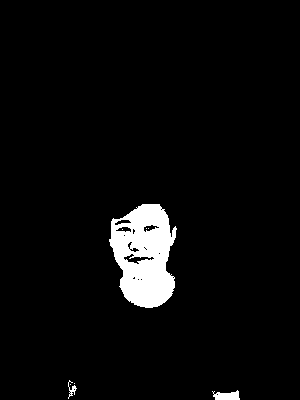

In [19]:
Image.fromarray(image_face)

In [20]:
ratio_filter_result

[(109, 176, 204, 307), (68, 76, 380, 398)]

83 [[18, 51], [48, 57]]
19 [[27, 30], [45, 50]]
30 27
55 [[9, 22], [29, 28]]
39 [[39, 22], [59, 28]]
A face


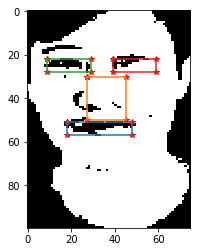

170 [[17, 89], [47, 95]]
80 [[26, 67], [44, 87]]
67 26
50 [[27, 66], [47, 72]]
0 [[0, 0], [0, 0]]
Not a Face


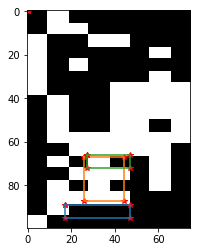

In [21]:
for min_col, max_col, min_row, max_row in ratio_filter_result:
    image_face_new = Image.fromarray(image_face).crop((min_col, min_row, max_col, max_row)).convert('L').resize((75, 100))
    imshow(image_face_new)
    
    
    image_face_new_arr = array(image_face_new)
    
    # Mouth
    mouth_position = find_mouth(image_face_new_arr)
    mouth_left_position = mouth_position[0][0]
    mouth_top_position = mouth_position[0][1]
    mouth_right_position = mouth_position[1][0]
    mouth_bottom_position = mouth_position[1][1]

    x = [mouth_left_position, mouth_right_position, mouth_right_position, mouth_left_position, mouth_left_position]
    y = [mouth_top_position, mouth_top_position, mouth_bottom_position, mouth_bottom_position, mouth_top_position]

    plot(x, y, 'r*')
    plot(x, y)
        
    # Nose
    nose_position = find_nose(image_face_new_arr, mouth_top_position, mouth_left_position, mouth_right_position)
    nose_left_position = nose_position[0][0]
    nose_top_position = nose_position[0][1]
    nose_right_position = nose_position[1][0]
    nose_bottom_position = nose_position[1][1]

    x = [nose_left_position, nose_right_position, nose_right_position, nose_left_position, nose_left_position]
    y = [nose_top_position, nose_top_position, nose_bottom_position, nose_bottom_position, nose_top_position]

    plot(x, y, 'r*')
    plot(x, y)
    
    # Left Eye
    left_eye_position = find_left_eye(image_face_new_arr, nose_top_position, nose_left_position)
    left_eye_left_position = left_eye_position[0][0]
    left_eye_top_position = left_eye_position[0][1]
    left_eye_right_position = left_eye_position[1][0]
    left_eye_bottom_position = left_eye_position[1][1]

    x = [left_eye_left_position, left_eye_right_position, left_eye_right_position, left_eye_left_position, left_eye_left_position]
    y = [left_eye_top_position, left_eye_top_position, left_eye_bottom_position, left_eye_bottom_position, left_eye_top_position]

    plot(x, y, 'r*')
    plot(x, y)

    # Right Eye
    right_eye_position = find_right_eye(image_face_new_arr, left_eye_top_position, left_eye_bottom_position, left_eye_right_position)
    right_eye_left_position = right_eye_position[0][0]
    right_eye_top_position = right_eye_position[0][1]
    right_eye_right_position = right_eye_position[1][0]
    right_eye_bottom_position = right_eye_position[1][1]

    x = [right_eye_left_position, right_eye_right_position, right_eye_right_position, right_eye_left_position, right_eye_left_position]
    y = [right_eye_top_position, right_eye_top_position, right_eye_bottom_position, right_eye_bottom_position, right_eye_top_position]

    plot(x, y, 'r*')
    plot(x, y)
    
    if (right_eye_position[2] == 0 or left_eye_position[2] == 0 or nose_position[2] == 0 or mouth_position[2] == 0):
        print('Not a Face')
    else:
        print('A face')
    show()